For Powerline data 
- Save the raw data to parquet file
- Join w veg data to reduce # of grids
  - Exclude water, agricultural lands, and urban areas based on the vegetation type data.

In [1]:
# Force garbage collection
import gc
gc.collect()

34

In [4]:
# del all variables
import sys
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

In [5]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyproj
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime

In [6]:
# check python version and all packages version
def check_python_version():
    import sys
    print("Python version")
    print (sys.version)
    print("Pandas version")
    print(pd.__version__)
    print("Geopandas version")
    print(gpd.__version__)
    print("Xarray version")
    print(xr.__version__)
    print("Pyproj version")
    print(pyproj.__version__)

check_python_version()

Python version
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version
2.2.2
Geopandas version
0.14.2
Xarray version
2023.6.0
Pyproj version
3.6.1


In [8]:
files = os.listdir('../../Extended_Data/Powerline/')
# only check files ending with .nc
files = [f for f in files if f.endswith('.nc')]
files

['transmission_line_density.CA.nc']

In [9]:
data_dir = '../../Extended_Data/Powerline/'
file = files[0]
print(file)

transmission_line_density.CA.nc


In [13]:
ds = xr.open_dataset(os.path.join(data_dir, file))
print(f"File: {file}")
print(f"Dimensions: {ds.dims}")
print(f"Coordinates: {ds.coords}")
print(f"Data variables: {ds.data_vars}")

File: transmission_line_density.CA.nc
Dimensions: Frozen({'lat': 585, 'lon': 1386})
Coordinates: Coordinates:
  * lat      (lat) float64 25.07 25.11 25.15 25.19 ... 49.28 49.32 49.36 49.4
  * lon      (lon) float64 -124.8 -124.7 -124.7 -124.6 ... -67.14 -67.1 -67.06
Data variables: Data variables:
    line_density_km_per_cell  (lat, lon) float64 ...


In [37]:
ds

<xarray.Dataset>
Dimensions:                   (lat: 585, lon: 1386)
Coordinates:
  * lat                       (lat) float64 25.07 25.11 25.15 ... 49.36 49.4
  * lon                       (lon) float64 -124.8 -124.7 ... -67.1 -67.06
Data variables:
    line_density_km_per_cell  (lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [15]:
powerline_pd = ds.to_dataframe().reset_index()

In [16]:
powerline_pd.head()

,lat,lon,line_density_km_per_cell
0,25.066667,-124.766667,0.0
1,25.066667,-124.725000,0.0
2,25.066667,-124.683333,0.0
3,25.066667,-124.641667,0.0
4,25.066667,-124.600000,0.0


In [18]:
powerline_pd.shape

(810810, 3)

In [17]:
reference_weather_data = pd.read_parquet('../../Clean_Data/Weather_Data/Extended_Weather_Data/wind_speed.parquet')
reference_weather_data = reference_weather_data[reference_weather_data['day']=='1998-01-01']
reference_weather_data = reference_weather_data[['lon', 'lat']].drop_duplicates()
reference_weather_data.shape

(61404, 2)

In [19]:
powerline_pd_lon_lat = powerline_pd[['lon', 'lat']].drop_duplicates()
powerline_pd_lon_lat.shape

(810810, 2)

In [20]:
test_merge = powerline_pd_lon_lat.merge(reference_weather_data, on=['lon', 'lat'], how='inner')
# if test_merge.shape is same as reference_weather_data, then the merge is successful
if test_merge.shape == reference_weather_data.shape:
    print("Merge successful")
else:
    # print test_merge shape and reference_weather_data shape
    print(f"Merge failed: {test_merge.shape} != {reference_weather_data.shape}")

Merge successful


## Missing Rate

In [23]:
powerline_pd.dtypes

lat                         float64
lon                         float64
line_density_km_per_cell    float64
dtype: object

In [24]:
powerline_pd['line_density_km_per_cell'].isnull().mean()

0.0

## Save Data

In [25]:
path_to_save = '../../Clean_Data/Extended_Data/Powerline'
# Ensure the output directory exists
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)

output_file = f'{path_to_save}/{file.split(".")[0]}.parquet'
powerline_pd.to_parquet(output_file)

print(f"Saved {file} as {output_file}")

Saved transmission_line_density.CA.nc as ../../Clean_Data/Extended_Data/Powerline/transmission_line_density.parquet


In [26]:
import gc
gc.collect()

658

## Merge w Veg Data

In [79]:
# clean up memory
gc.collect()
# delete all dataframes
for var in list(globals().keys()):
    if isinstance(globals()[var], pd.DataFrame):
        del globals()[var]

In [ ]:
import os
from datetime import datetime
import pandas as pd

In [27]:
# the data is generated from 02 Veg Data Extract.ipynb
veg_data = pd.read_parquet('../../Clean_Data/lon_lat_pair_weather_match_veg_v2.parquet')

In [28]:
veg_data.shape

(17703, 7)

In [29]:
veg_data.head()

,lon,lat,type,distance,veg_type_details,fire_attribute,veg
0,-124.391667,40.441667,7.0,1.826642,Native Coastal Sage Scrub - fire,fire,Native Coastal Sage Scrub
1,-124.391667,40.400000,25.0,1.827314,Native Oak Woodland - fire,fire,Native Oak Woodland
2,-124.350000,40.566667,1.0,1.824622,Agriculture - low,low,Agriculture
3,-124.350000,40.525000,8.0,1.825296,Native Coastal Sage Scrub - mesic,mesic,Native Coastal Sage Scrub
4,-124.350000,40.483333,25.0,1.825969,Native Oak Woodland - fire,fire,Native Oak Woodland


In [30]:
veg_data[['lon', 'lat']].duplicated().sum()

0

In [31]:
veg_data_filter = veg_data[~veg_data['veg'].str.contains('Water|Urban|Agriculture')]

In [32]:
veg_data_filter.shape

(14383, 7)

In [33]:
file = 'transmission_line_density.parquet'

In [34]:
path_to_read = '../../Clean_Data/Extended_Data/Powerline'
path_to_save = '../../Clean_Data/Extended_Data_w_Veg_Filter/Powerline'
# Ensure the output directory exists
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)

print("Task: Data cleaning on Powerline data with vegetation filter")
print(f"Processing started on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


dat = pd.read_parquet(f'{path_to_read}/{file}')
print(f"Processing file: {file}, shape: {dat.shape}")
dat_filtered = pd.merge(dat, veg_data_filter[['lon', 'lat']], on=['lon', 'lat'], how='inner')
print(f"Filtered DataFrame shape: {dat_filtered.shape}")
del dat  # Free up memory
dat_filtered.to_parquet(f'{path_to_save}/{file}')

Task: Data cleaning on Powerline data with vegetation filter
Processing started on: 2025-06-14 13:23:56
Processing file: transmission_line_density.parquet, shape: (810810, 3)
Filtered DataFrame shape: (14383, 3)


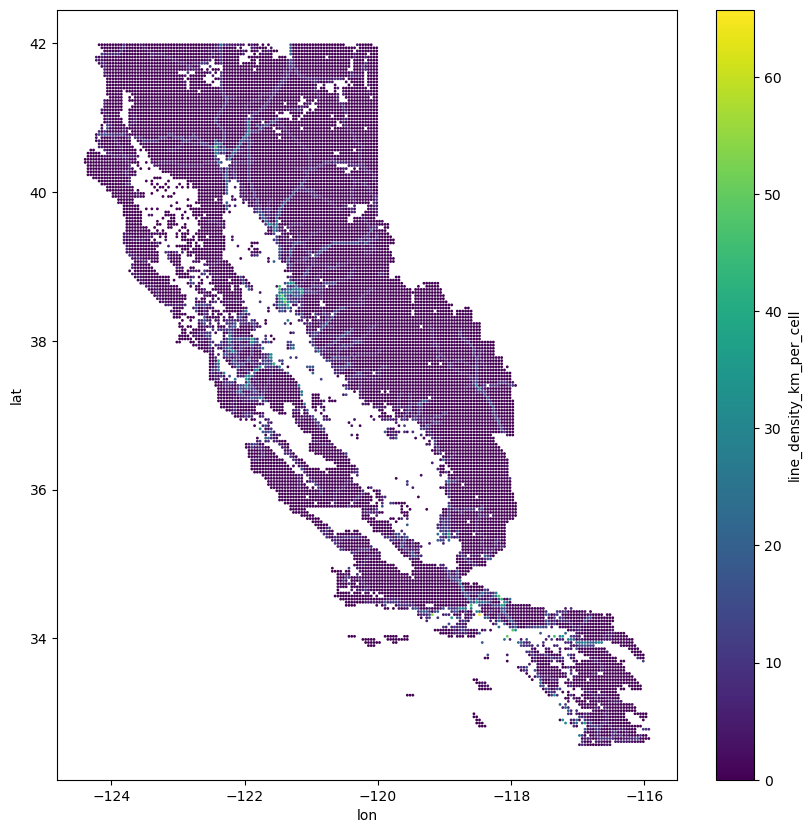

In [36]:
dat_filtered.plot(kind='scatter', x='lon', y='lat', c='line_density_km_per_cell', cmap='viridis', s=1, figsize=(10, 10))
plt.show()